In [1]:
import pandas as pd 
from medpy.metric import dc, hd, hd95
import numpy as np

physician_annotations = "martina_annotations.csv"
df = pd.read_csv(physician_annotations)
datasets = df["Dataset"].unique()

ground_truth = np.zeros([180, 240])
pred = np.zeros([180, 240])
    
pos = 0 

for dataset in datasets:
    annotations = df[df["Dataset"] == dataset]
    segmentations = pd.read_csv("Subsets/" + dataset + ".csv")
    column_id = segmentations.columns[0]
    segmentations = segmentations.rename(columns={column_id: "ImageID"})
    
    images = annotations.ImageID.unique()
    
    for image in images:
        pred_row = segmentations[segmentations["ImageID"] == image]
        gt_row = annotations[annotations["ImageID"] == image]
        
        GT_Landmarks = np.array(eval(gt_row["Landmarks"].values[0])).astype(np.float32).reshape(-1)
        PRED_Landmarks = np.array(eval(pred_row["Landmarks"].values[0])).astype(np.float32).reshape(-1)
        
        ground_truth[pos, :] = GT_Landmarks
        pred[pos, :] = PRED_Landmarks
        
        pos += 1

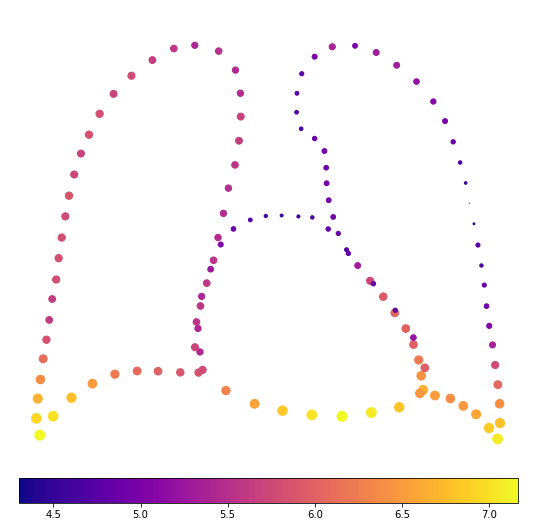

In [16]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Average shape
avg_landmarks = np.mean(ground_truth, axis=0).reshape(-1, 2)
mse_per_landmark = np.mean((ground_truth - pred)**2, axis=0)
mse_per_landmark = mse_per_landmark.reshape(-1, 2)
mse_per_landmark = np.mean(mse_per_landmark, axis=1)

mse_per_landmark = np.log(mse_per_landmark)

# Create a sizes array to use in the scatterplot
sizes = np.zeros(len(mse_per_landmark))
# increase the size of the points according to the MSE, but go linearly from 0 to 1
sizes = (mse_per_landmark - np.min(mse_per_landmark)) / (np.max(mse_per_landmark) - np.min(mse_per_landmark)) + 0.001

plt.figure(figsize=(8, 8))
scatter = plt.scatter(avg_landmarks[:, 0], avg_landmarks[:, 1], c=mse_per_landmark, cmap='plasma', s = 100 * sizes)

plt.xlim(100, 1024-100)
plt.ylim(100, 1024-180)
plt.axis("off")
plt.gca().invert_yaxis()

# aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

plt.colorbar(scatter, orientation='horizontal', pad=0.00, shrink=0.9)  # Reduced padding and shrink colorbar
plt.tight_layout()
plt.savefig("mse_per_landmark.pdf", dpi=300)
plt.show()
